In [8]:
#Code by David Roberts https://www.kaggle.com/code/davidbroberts/tensorflow-transfer-learning/notebook

import os
import math
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lib.datasets.synthetic as synthetic
import torchvision
import lib.datasets.maze as maze 
import lib.datasets.mnist as mnist
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.loggers.loggers as loggers
import lib.loggers.logger_utils as logger_utils
from lib.models.models import UniformRate, UniformVariantRate, GaussianTargetRate
import lib.utils.utils as utils
import numpy as np
from lib.datasets import dataset_utils
from torch.utils.data import Dataset, DataLoader
def show_images(images, n=8):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy().astype("uint8"), cmap='gray')
        plt.axis("off")
    plt.show()

def plot_samples(samples, im_size=0, axis=False, im_fmt=None):
    """Plot samples."""
    plt.scatter(samples[:, 0], samples[:, 1], marker=".")
    plt.axis("equal")
    if im_size > 0:
        plt.xlim(-im_size, im_size)
        plt.ylim(-im_size, im_size)
    if not axis:
        plt.axis("off")
    plt.show()
    plt.close()


In [ ]:
from config.maze_config.config_bert_maze import get_config
cfg = get_config()
model = model_utils.create_model(cfg, cfg.device)
print("Number of Parameters: ", sum([p.numel() for p in model.parameters()]))

In [ ]:
from lib.networks.ddsm_networks import ProteinScoreNet
from config.maze_config.config_hollow_maze import get_config
cfg = get_config()
cfg.device = 'cuda'



D = cfg.model.concat_dim = 1024
S = cfg.data.S = 5
B = cfg.data.batch_size
net = ProteinScoreNet(cfg).to(cfg.device)
ts = torch.rand((B,), device=cfg.device) * (1.0 - 0.01) + 0.01
x = torch.randint(low=0, high=S, size=(B, D), device='cuda')
x_out = net(x, ts)
print(x_out.shape)


In [ ]:
from config.mnist_config.config_bert_mnist import get_config
cfg = get_config()
device = cfg.device 
device = 'cuda'
mnist_dataset = dataset_utils.get_dataset(cfg, device, cfg.data.location)
cfg.data.batch_size = 10
mnist_dl = DataLoader(mnist_dataset,
                                cfg.data.batch_size, shuffle=cfg.data.shuffle,
                                num_workers=0)
                                #worker_init_fn=worker_init_fn)

In [9]:
from config.synthetic_config.config_ebm_synthetic import get_config
cfg = get_config()
location = "lib/datasets/Synthetic/data_2spirals.npy"
device = cfg.device 
device = 'cuda'
mnist_dataset = dataset_utils.get_dataset(cfg, device, location)
cfg.data.batch_size = 1000
mnist_dl = DataLoader(mnist_dataset,
                                cfg.data.batch_size, shuffle=cfg.data.shuffle,
                                num_workers=0)
                                #worker_init_fn=worker_init_fn)


remapping binary repr with gray code
cuda:0
Time points tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.6895, 0.3105],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.6895, 0.3105],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.6895, 0.3105],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.6895, 0.3105],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.6895, 0.3105]

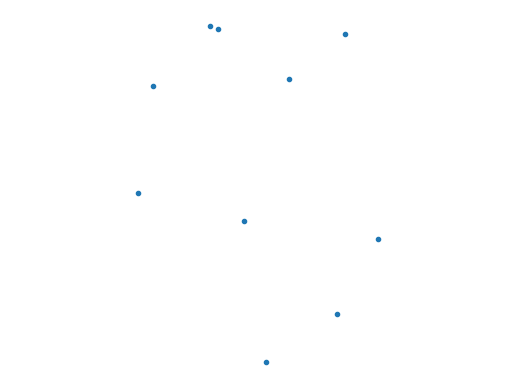

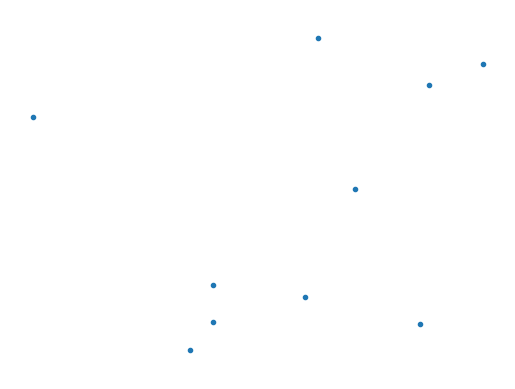

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [14]:
cfg.model.rate_const = 0.7 #0.00009
cfg.model.t_func = "log_sqr"
#model = UniformRate(cfg, device)
model = UniformVariantRate(cfg, device)
# model = GaussianTargetRate(cfg, device)
S = 2
bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)

for minibatch in mnist_dl:
    print(minibatch.device)
    B, D = minibatch.shape
    minibatch = minibatch.view(B, D).to('cpu')
    ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) *1
    print("Time points", ts[:9])

    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)


    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(torch.arange(B, device=device), (tuple(range(1, minibatch.dim()))))
    qt0 = qt0[b, minibatch.long()]
    print(qt0_rows_reg, qt0_rows_reg.shape)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

        #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(
        rate_vals_square_dimsum
    )


    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(
        rate_new_val_probs
    )

    square_newval_samples = (
        square_newvalcat.sample()
    )  # (B, ) taking values in [0, S)


    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    x_tilde = synthetic.bin2float(x_tilde.detach().cpu().numpy().astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
    minibatch = synthetic.bin2float(minibatch.detach().cpu().numpy().astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
    plot_samples(minibatch) # * 127.5
    plot_samples(x_tilde) # * 127.5
    noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    noise_x = synthetic.bin2float(noise_x.detach().cpu().numpy().astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
    plot_samples(noise_x) # * 127.5

In [ ]:
cfg.model.rate_const = 0.1 #0.00009
cfg.model.t_func = "log"

cfg.model.time_base = 3
cfg.model.time_exp = 100
cfg.model.rate_sigma = 6.0
cfg.model.Q_sigma = 512.0
#model = UniformRate(cfg, device)
model = UniformVariantRate(cfg, device)
# model = GaussianTargetRate(cfg, device)
S = 256


for minibatch in mnist_dl:
    B, C, H, W = minibatch.shape
    print(minibatch.device)
    D = C*H*W
    minibatch = minibatch.view(B, D).to('cpu')
    ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) *1
    print("Time points", ts[:9])

    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)


    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(torch.arange(B, device=device), (tuple(range(1, minibatch.dim()))))
    qt0 = qt0[b, minibatch.long()]
    print(qt0_rows_reg, qt0_rows_reg.shape)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

        #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(
        rate_vals_square_dimsum
    )


    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(
        rate_new_val_probs
    )

    square_newval_samples = (
        square_newvalcat.sample()
    )  # (B, ) taking values in [0, S)


    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    x_tilde = x_tilde.view(B, C, H, W)

    show_images(minibatch.view(B, C, H, W).detach().cpu(), n=9) # * 127.5
    show_images(x_tilde.detach().cpu(), n=9) # * 127.5
    noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    show_images(noise_x.view(B, C, H, W).detach().cpu(), n=9) # * 127.5
    break

In [ ]:
from config.maze_config.config_hollow_maze import get_config
cfg = get_config()
device = cfg.device 
device = 'cuda'
maze_dataset = dataset_utils.get_dataset(cfg, device)
cfg.data.batch_size = 10
maze_dl = DataLoader(maze_dataset,
                                cfg.data.batch_size, shuffle=cfg.data.shuffle,
                                num_workers=0)
                                #worker_init_fn=worker_init_fn)

In [ ]:
cfg.model.rate_const = 2.3 # 2.3 log_sqr t=0.5T 0.4763, 0.2619, 0.2619
cfg.model.t_func = "log_sqr"
cfg.model.time_base = 1
cfg.model.time_exp = 250
#model = UniformRate(cfg, 'cuda')
model = UniformVariantRate(cfg, 'cuda')
S = 3


for minibatch in maze_dl:
    B, C, H, W = minibatch.shape
    print(minibatch.device)
    D = C*H*W
    minibatch = minibatch.view(B, D)
    ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) * 1
    #ts = torch.linspace(0.01, 1, B, device=device)
    print("Time points", ts[:9])

    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)


    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(torch.arange(B, device=device), (tuple(range(1, minibatch.dim()))))
    qt0 = qt0[b, minibatch.long()].view(-1, S)
    print(qt0_rows_reg)# , qt0)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

        #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(
        rate_vals_square_dimsum
    )


    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(
        rate_new_val_probs
    )

    square_newval_samples = (
        square_newvalcat.sample()
    )  # (B, ) taking values in [0, S)


    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    x_tilde = x_tilde.view(B, C, H, W)

    show_images(minibatch.view(B, C, H, W).detach().cpu()* 127.5, n=B) # * 127.5
    show_images(x_tilde.detach().cpu() * 127.5, n=B) # * 127.5
    noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    show_images(noise_x.view(B, C, H, W).detach().cpu() * 127.5, n=B) # * 127.5
    break

In [ ]:
for minibatch in maze_dl:
    B, C, H, W = minibatch.shape
    show_images(minibatch.view(B, C, H, W).detach().cpu()* 127.5, n=8) 
    break

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from torch.nn import functional as F
D= 1
S = 256
x = torch.randint(low=0, high=S, size=(B, D))
print(x.shape)
x = F.one_hot(x.long(), S)
out = x.permute(0, 2, 1).float()
print(out.shape, type(out))
#out = x
lin = nn.Conv1d(S, 256*2, kernel_size=9, padding=4)
print(lin(out).shape)

In [ ]:
import lib.utils.utils as utils
cfg.model.rate_const = 0.5
cfg.model.t_func = "log"
cfg.model.time_base = 5
cfg.model.time_exp = 5
model = UniformRate(cfg, 'cuda')
model = UniformVariantRate(cfg, 'cuda')
device = 'cpu'
S = 3
min_time = 0.01


for minibatch in mnist_dataset:
    

    if len(minibatch.shape) == 4:
        B, C, H, W = minibatch.shape
        minibatch = minibatch.view(B, C * H * W)
    # hollow xt, t, l_all, l_xt geht rein
    B = minibatch.shape[0]
    ts = torch.rand((B,), device=device) * (1.0 - min_time) + min_time
    ts = torch.ones((B,)) * 1
    print(ts[:9])
    #

    qt0 = model.transition(ts)  # (B, S, S)

    # rate = model.rate(ts)  # (B, S, S)

    b = utils.expand_dims(torch.arange(B, device=device), (tuple(range(1, minibatch.dim()))))
    qt0 = qt0[b, minibatch.long()]

    # log loss
    log_qt0 = torch.where(qt0 <= 0.0, -1e9, torch.log(qt0))
    x_tilde = torch.distributions.categorical.Categorical(
        logits=log_qt0
    ).sample()  # bis hierhin <1 sek

    x_tilde = x_tilde.view(B, C, H, W)
    print(torch.mean(x_tilde[1,:, :, :].float()))
    #print(x_tilde[0,0, :, :].std())
    show_images(minibatch.view(B, C, H, W) * 127.5, n=9)
    show_images(x_tilde * 127.5, n=9)
    noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    show_images(noise_x.view(B, C, H, W) * 127.5, n=9)
    break


In [ ]:
# int log(t**2 + 1)
t = np.linspace(0.01, 1, 1000)
f = 2 * t / (t**2 + 1)
f_int = np.log(t**2 + 1)
f_cos = np.sin(t) / np.sqrt(np.cos(t))
a = 5
b = 5
f_log = a * np.log(b) * b**t
plt.plot(f, label='log sqr')
plt.plot(f_int, label='int log sqr')
plt.plot(f_cos, label='cos')
plt.plot(f_log, label='log')
plt.show()